## Problem Statement:
### Develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems.

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras .applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [3]:
import zipfile
with zipfile.ZipFile('leapGestRecog.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
os.listdir('leapGestRecog')

['.ipynb_checkpoints',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09']

In [4]:
dataset_dir = 'leapGestRecog'

### Load Pretrained model (VGG16)

In [5]:
# Load VGG16 without the top classification layers
conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(128,128,3)
)

In [6]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)       │ (None, 128, 128, 3)     │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block1_conv1 (Conv2D)          │ (None, 128, 128, 64)    │        1,792 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block1_conv2 (Conv2D)          │ (None, 128, 128, 64)    │       36,928 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block1_pool (MaxPooling2D)     │ (None, 64, 64, 64)      │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block2_conv1 (Conv2D)          │ (None, 64, 64, 128)     │       73,856 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block2_conv2 (Conv2D)          │ (None, 64, 64, 128)     │      147,584 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block2_pool (MaxPooling2D)     │ (None, 32, 32, 128)     │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block3_conv1 (Conv2D)          │ (None, 32, 32, 256)     │      295,168 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block3_conv2 (Conv2D)          │ (None, 32, 32, 256)     │      590,080 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block3_conv3 (Conv2D)          │ (None, 32, 32, 256)     │      590,080 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block3_pool (MaxPooling2D)     │ (None, 16, 16, 256)     │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block4_conv1 (Conv2D)          │ (None, 16, 16, 512)     │    1,180,160 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block4_conv2 (Conv2D)          │ (None, 16, 16, 512)     │    2,359,808 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block4_conv3 (Conv2D)          │ (None, 16, 16, 512)     │    2,359,808 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block4_pool (MaxPooling2D)     │ (None, 8, 8, 512)       │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block5_conv1 (Conv2D)          │ (None, 8, 8, 512)       │    2,359,808 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block5_conv2 (Conv2D)          │ (None, 8, 8, 512)       │    2,359,808 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block5_conv3 (Conv2D)          │ (None, 8, 8, 512)       │    2,359,808 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ block5_pool (MaxPooling2D)     │ (None, 4, 4, 512)       │            0 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Build the CNN Model

In [7]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))

In [9]:
conv_base.trainable = False

In [10]:
# Data Augmentation and Preprocessing
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Prepare data for training and validation
train_generator = train_datagen.flow_from_directory(
    directory= 'leapGestRecog',
    target_size=(128,128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 20000 images belonging to 11 classes.


In [12]:
validation_generator = test_datagen.flow_from_directory(
    directory= 'leapGestRecog',
    target_size=(128,128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    #subset='validation'
)

Found 20000 images belonging to 11 classes.


In [13]:
#Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label


In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [15]:
# Train Model
history = model.fit(
    train_generator,
    epochs=7,
    validation_data=validation_generator)

Epoch 1/7


C:\Users\NISHITA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 3750s 6s/step - accuracy: 0.4020 - loss: 1.7872 - val_accuracy: 0.9512 - val_loss: 0.3380
Epoch 2/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 5685s 9s/step - accuracy: 0.7257 - loss: 0.7987 - val_accuracy: 0.9688 - val_loss: 0.1437
Epoch 3/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3214s 5s/step - accuracy: 0.7773 - loss: 0.6285 - val_accuracy: 0.9793 - val_loss: 0.0946
Epoch 4/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3286s 5s/step - accuracy: 0.8126 - loss: 0.5309 - val_accuracy: 0.9831 - val_loss: 0.0522
Epoch 5/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 2981s 5s/step - accuracy: 0.8341 - loss: 0.4717 - val_accuracy: 0.9834 - val_loss: 0.0615
Epoch 6/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3010s 5s/step - accuracy: 0.8450 - loss: 0.4340 - val_accuracy: 0.9829 - val_loss: 0.0514
Epoch 7/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3408s 5s/step - accuracy: 0.8452 - loss: 0.4267 - val_accuracy: 0.9777 - val_loss: 0.0516


In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

625/625 ━━━━━━━━━━━━━━━━━━━━ 1388s 2s/step - accuracy: 0.9777 - loss: 0.0515
Validation Accuracy: 97.77%


In [18]:
# Save the trained model
model.save('hand_gesture_recognition_model.h5') 

### Visualize Predictions

Text(0.5, 1.0, 'Training and Validation Accuracy')

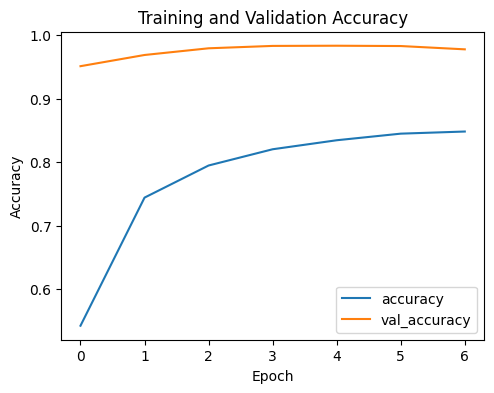

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

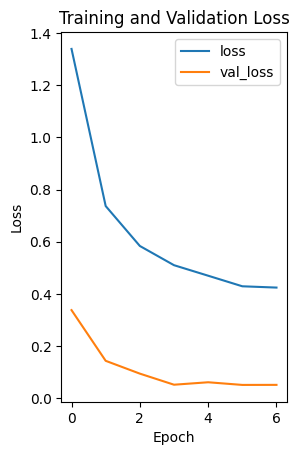

In [20]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 

### Predict the hand gesture

In [23]:
# Function to predict gesture from an image
import cv2
def predict_gesture(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (128,128))
    img_preprocessed = np.expand_dims(img_resized, axis=0) / 255.0
    prediction = model.predict(img_preprocessed)
    gesture = np.argmax(prediction)
    return gesture

In [26]:
gesture = predict_gesture('leapGestRecog/00/07_ok/frame_00_07_0003.png')
print(f'Predicted gesture: {gesture}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted gesture: 3


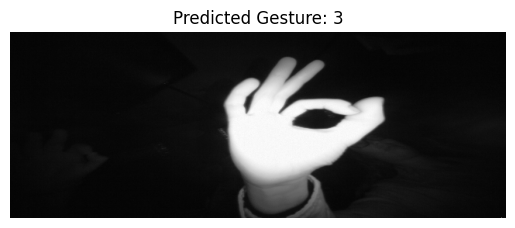

In [28]:
img = cv2.imread('leapGestRecog/00/07_ok/frame_00_07_0003.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
plt.imshow(img_rgb)
plt.title(f'Predicted Gesture: {gesture}')
plt.axis('off')
plt.show()